c:\Users\gleilsonpedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Mnist accuracy: 0.9729985788725722


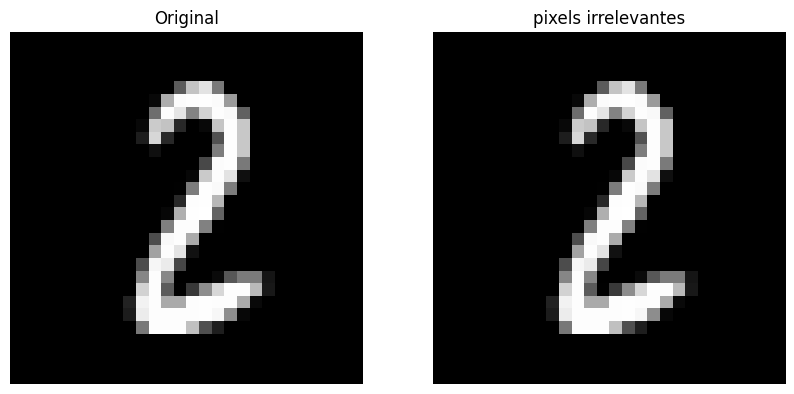

KeyboardInterrupt: 

In [39]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from z3 import *
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score 

# Carrega o dataset MNIST
mnist = fetch_openml('mnist_784', version=1, cache=True, parser='auto')
X, y = mnist.data, mnist.target
y = y.astype(np.uint8)

# Filtra as classes 2, 4 e 7
classes_to_keep = [2, 4, 7]
mask = np.isin(y, classes_to_keep)
X_filtered = X[mask]
y_filtered = y[mask]

# Divide os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, stratify=y_filtered)

# Pré-processamento dos dados (apenas para treino)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Treina o modelo de regressão logística
logistic_regression_classifier = LogisticRegression(multi_class='multinomial', max_iter=200)
logistic_regression_classifier.fit(X_train, y_train)

# Avalia a acurácia do modelo
predictions = logistic_regression_classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions) 
print("Mnist accuracy:", accuracy)

# Função para plotar a imagem MNIST
def plot_mnist_image(image):
    plt.imshow(image.reshape(28, 28), cmap='binary')
    plt.axis('off')
    plt.show()

# Define as variáveis reais para o Z3
real_vars_mnist = [Real('x_' + str(i)) for i in range(X_filtered.shape[1])]

# Define as restrições de domínio
domain_constraints_mnist = [
    x <= u for (x, u) in zip(real_vars_mnist, X_filtered.max(axis=0))
] + [
    x >= l for (l, x) in zip(X_filtered.min(axis=0), real_vars_mnist)
]

# Define as equações da regressão logística para cada classe
logistic_reg_terms_mnist = [
    logistic_regression_classifier.coef_[i] @ real_vars_mnist + logistic_regression_classifier.intercept_[i]
    for i in range(3)
]

logistic_reg1_term = logistic_reg_terms_mnist[0] # Termo da regressão logística para a classe 0
logistic_reg2_term = logistic_reg_terms_mnist[1] # classe 1
logistic_reg3_term = logistic_reg_terms_mnist[2] # classe 2

# Função para calcular a explicação minimal
def minimalExplanation(I, D, P):
    """
    Calcula a explicação minimal para uma predição de classe específica.

    Args:
        I: Array de entrada com features.
        D: Restrições de domínio das features.
        P: Fórmula lógica representando a predição da classe.

    Returns:
        E: Lista de restrições de igualdade para a entrada.
        red_pixels: Lista de índices dos pixels irrelevantes.
    """
    E = [x == u for x, u in zip(real_vars_mnist, I)]  # Cria restrições de igualdade para a entrada original
    solver = Solver() # cria o solver
    red_pixels = [] # variável que irá receber os pixels irrelevantes
    for i in range(len(E) - 1, -1, -1):
        solver.reset()
        E_temp = E.copy()
        del E_temp[i]

        solver.add(E_temp)
        solver.add(D)
        solver.add(Not(P))
        if solver.check() != sat:
            E = E_temp.copy()
            red_pixels.append(i)

    return E, red_pixels

# Função para pintar os pixels modificados em vermelho
def pintar_pixels(imagem, deleted_pixels):
    """
    Pinta os pixels modificados em vermelho na imagem.

    Args:
        imagem: A imagem MNIST.
        deleted_pixels: Lista de índices dos pixels modificados.

    Returns:
        imagem: A imagem MNIST com os pixels modificados em vermelho.
    """

    imagem = imagem.reshape(28, 28).astype(np.uint8)
    imagem_rgb = Image.fromarray(imagem).convert("RGB")
    pixels = imagem_rgb.load()
    vermelho = (255, 0, 0)

    for index in deleted_pixels:
        x = index % 28
        y = index // 28
        pixels[x, y] = vermelho

    return imagem_rgb


# Calcula e plota as explicações minimais para o MNIST
for i in range(4):
    # Define a fórmula lógica para a predição da classe
    if predictions[i] == 1:
        formula = And(logistic_reg1_term > logistic_reg2_term, logistic_reg1_term > logistic_reg3_term)

    elif predictions[i] == 5:
        formula = And(logistic_reg2_term > logistic_reg1_term, logistic_reg2_term > logistic_reg3_term)

    else:
        formula = And(logistic_reg3_term > logistic_reg1_term, logistic_reg3_term > logistic_reg2_term)

    img, red_pixel = minimalExplanation(X_test.iloc[i].to_numpy(), domain_constraints_mnist, formula)

    img_rgb = pintar_pixels(X_test.iloc[i].to_numpy().reshape(28, 28), red_pixel)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(X_test.iloc[i].to_numpy().reshape(28, 28), cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')

    axs[1].imshow(img_rgb)
    axs[1].set_title('pixels irrelevantes')
    axs[1].axis('off')

    plt.show()

c:\Users\gleilsonpedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Mnist accuracy: 0.9733143849676299


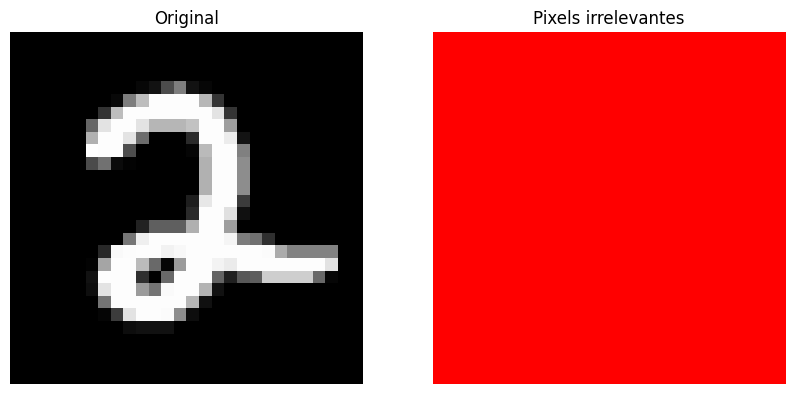

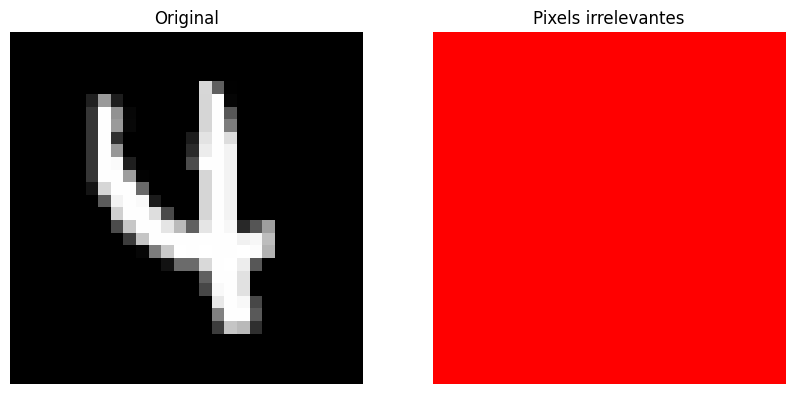

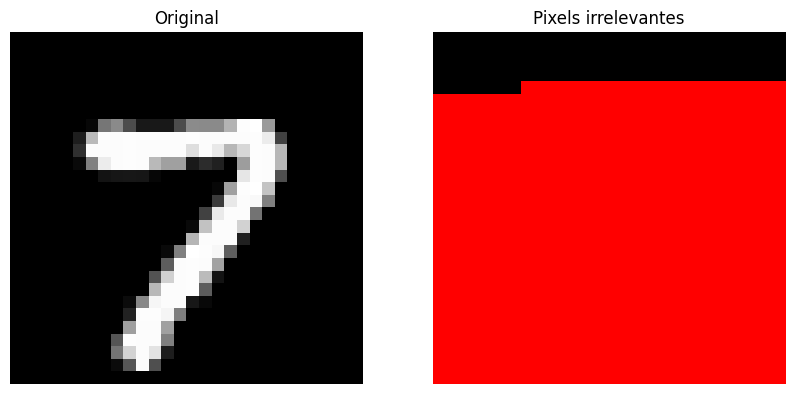

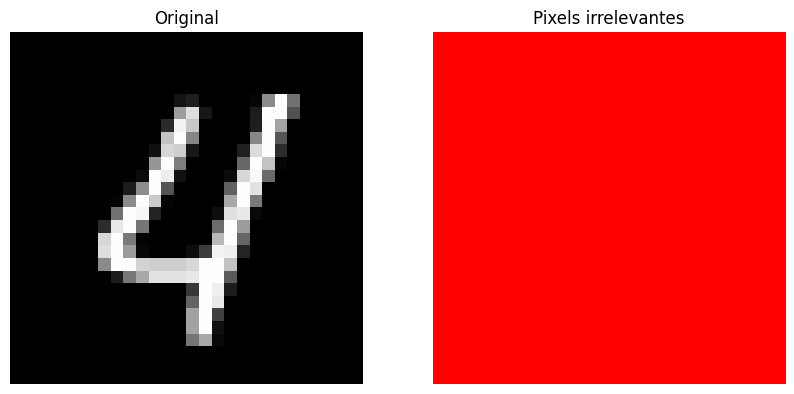

In [41]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from z3 import *
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Carrega o dataset MNIST
mnist = fetch_openml('mnist_784', version=1, cache=True, parser='auto')
X, y = mnist.data, mnist.target
y = y.astype(np.uint8)

# Filtra as classes 2, 4 e 7
classes_to_keep = [2, 4, 7]
mask = np.isin(y, classes_to_keep)
X_filtered = X[mask]
y_filtered = y[mask]

# Divide os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, stratify=y_filtered)

# Pré-processamento dos dados (apenas para treino)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Treina o modelo de regressão logística
logistic_regression_classifier = LogisticRegression(multi_class='multinomial', max_iter=200)
logistic_regression_classifier.fit(X_train, y_train)

# Avalia a acurácia do modelo
predictions = logistic_regression_classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Mnist accuracy:", accuracy)

# Função para plotar a imagem MNIST
def plot_mnist_image(image):
    plt.imshow(image.reshape(28, 28), cmap='binary')
    plt.axis('off')
    plt.show()

# Define as variáveis reais para o Z3
real_vars_mnist = [Real('x_' + str(i)) for i in range(X_filtered.shape[1])]

# Define as restrições de domínio
domain_constraints_mnist = [
    x <= u for (x, u) in zip(real_vars_mnist, X_filtered.max(axis=0))
] + [
    x >= l for (l, x) in zip(X_filtered.min(axis=0), real_vars_mnist)
]

# Define as equações da regressão logística para cada classe
logistic_reg_terms_mnist = [
    logistic_regression_classifier.coef_[i] @ real_vars_mnist + logistic_regression_classifier.intercept_[i]
    for i in range(3)
]

logistic_reg1_term = logistic_reg_terms_mnist[0]
logistic_reg2_term = logistic_reg_terms_mnist[1]
logistic_reg3_term = logistic_reg_terms_mnist[2]

# Função para encontrar os pixels irrelevantes usando Z3
def find_irrelevant_pixels(input_data, class_formula):
    """
    Usa o Z3 para encontrar os pixels irrelevantes que não alteram a predição da classe.

    Args:
        input_data: Array de entrada com features.
        class_formula: Fórmula lógica representando a predição da classe.

    Returns:
        deleted_pixels: Lista de índices dos pixels irrelevantes.
    """

    solver = Solver()
    solver.add(domain_constraints_mnist)
    solver.add([x == u for x, u in zip(real_vars_mnist, input_data)])
    solver.add(Not(class_formula))

    deleted_pixels = []
    for i in range(X_filtered.shape[1]):
        # Cria uma cópia das restrições
        temp_constraints = [c for c in solver.assertions()]

        # Define a variável como "don't care"
        temp_constraints.remove(Real('x_' + str(i)) == input_data[i])
        temp_constraints.append(Real('x_' + str(i)) == Real('x_' + str(i)))

        # Verifica se a restrição ainda é satisfatível
        solver.reset()
        solver.add(temp_constraints)
        if solver.check() == sat:
            deleted_pixels.append(i)

    return deleted_pixels

# Função para pintar os pixels em vermelho
def pintar_pixels(imagem, deleted_pixels):
    """
    Pinta os pixels modificados em vermelho na imagem.

    Args:
        imagem: A imagem MNIST.
        deleted_pixels: Lista de índices dos pixels modificados.

    Returns:
        imagem: A imagem MNIST com os pixels modificados em vermelho.
    """

    imagem = imagem.reshape(28, 28).astype(np.uint8)
    imagem_rgb = Image.fromarray(imagem).convert("RGB")
    pixels = imagem_rgb.load()
    vermelho = (255, 0, 0)

    for index in deleted_pixels:
        x = index % 28
        y = index // 28
        pixels[x, y] = vermelho

    return imagem_rgb

# Plota as explicações minimais para o MNIST
for i in range(4):
    # Define a fórmula lógica para a predição da classe
    if predictions[i] == 1:
        formula = And(logistic_reg1_term > logistic_reg2_term, logistic_reg1_term > logistic_reg3_term)

    elif predictions[i] == 5:
        formula = And(logistic_reg2_term > logistic_reg1_term, logistic_reg2_term > logistic_reg3_term)

    else:
        formula = And(logistic_reg3_term > logistic_reg1_term, logistic_reg3_term > logistic_reg2_term)

    # Encontra os pixels irrelevantes
    deleted_pixels = find_irrelevant_pixels(X_test.iloc[i].to_numpy(), formula)

    # Pinta os pixels irrelevantes
    img_rgb = pintar_pixels(X_test.iloc[i].to_numpy().reshape(28, 28), deleted_pixels)

    # Plota as imagens original e modificada
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(X_test.iloc[i].to_numpy().reshape(28, 28), cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')

    axs[1].imshow(img_rgb)
    axs[1].set_title('Pixels irrelevantes')
    axs[1].axis('off')

    plt.show()

c:\Users\gleilsonpedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mnist accuracy: 0.9484536082474226
Iris accuracy: 0.9555555555555556
[x_pixel1 <= 0, x_pixel2 <= 0, x_pixel3 <= 0, x_pixel4 <= 0, x_pixel5 <= 0, x_pixel6 <= 0, x_pixel7 <= 0, x_pixel8 <= 0, x_pixel9 <= 0, x_pixel10 <= 0, x_pixel11 <= 0, x_pixel12 <= 0, x_pixel13 <= 0, x_pixel14 <= 0, x_pixel15 <= 0, x_pixel16 <= 0, x_pixel17 <= 0, x_pixel18 <= 0, x_pixel19 <= 0, x_pixel20 <= 0, x_pixel21 <= 0, x_pixel22 <= 0, x_pixel23 <= 0, x_pixel24 <= 0, x_pixel25 <= 0, x_pixel26 <= 0, x_pixel27 <= 0, x_pixel28 <= 0, x_pixel29 <= 0, x_pixel30 <= 0, x_pixel31 <= 0, x_pixel32 <= 0, x_pixel33 <= 0, x_pixel34 <= 0, x_pixel35 <= 0, x_pixel36 <= 0, x_pixel37 <= 0, x_pixel38 <= 0, x_pixel39 <= 0, x_pixel40 <= 0, x_pixel41 <= 0, x_pixel42 <= 0, x_pixel43 <= 210, x_pixel44 <= 255, x_pixel45 <= 38, x_pixel46 <= 0, x_pixel47 <= 0, x_pixel48 <= 0, x_pixel49 <= 0, x_pixel50 <= 0, x_pixel51 <= 0, x_pixel52 <= 0, x_pixel53 <= 0, x_pixel54 <= 0, x_pixel55 <= 0, x_pixel56 <= 0, x_pixel57 <= 0, x_pixel58 <= 0, x_pixe

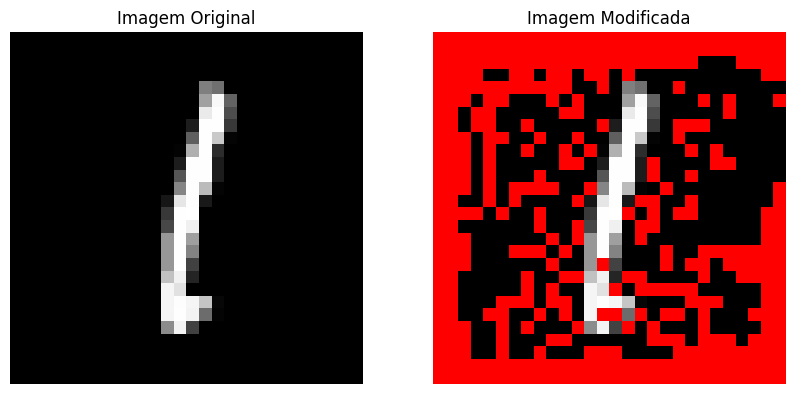

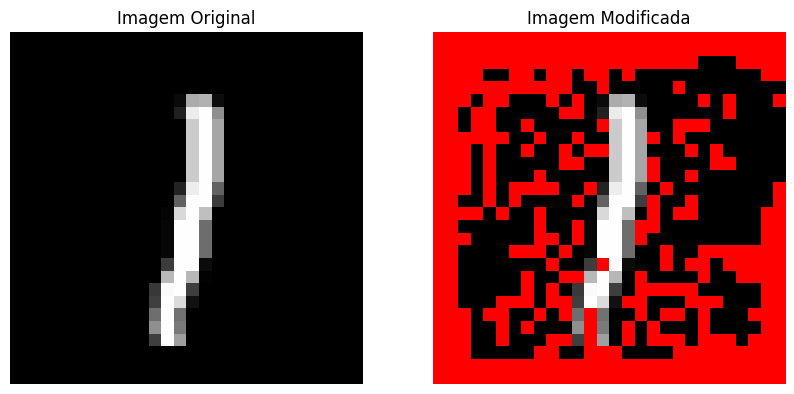

KeyboardInterrupt: 

In [1]:
# %%
from sklearn.datasets import fetch_openml
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from z3 import *
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from PIL import Image


mnist = fetch_openml('mnist_784', version=1, cache=True, parser='auto')
X_iris, y_iris = load_iris(return_X_y=True, as_frame=True)

scaler = MinMaxScaler()
scaler.fit(mnist.data)
scaler.set_output(transform='pandas')
data_scaled = scaler.transform(mnist.data)

scaler.fit(X_iris)
scaler.set_output(transform='pandas')
X_iris = scaler.transform(X_iris)

X, y = mnist.data, mnist.target
y = y.astype(np.uint8)

classes_to_keep = [1, 5, 8]
mask = np.isin(y, classes_to_keep)
X_filtered = X[mask]
y_filtered = y[mask]


X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, stratify=y_filtered)

X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, y_iris, test_size=0.3, stratify=y_iris)

logistic_regression_classifier = LogisticRegression(multi_class='multinomial', max_iter=200)
iris_class = LogisticRegression(multi_class='multinomial', max_iter=200)


logistic_regression_classifier.fit(X_train, y_train)
iris_class.fit(X_train_iris, y_train_iris)


predictions = logistic_regression_classifier.predict(X_test)
predictions_iris = iris_class.predict(X_test_iris)


predictions_iris


accuracy = accuracy_score(y_test, predictions)
accuracy_iris = accuracy_score(y_test_iris, predictions_iris)
print("Mnist accuracy:", accuracy)
print("Iris accuracy:", accuracy_iris)

def plot_mnist_image(image):
    plt.imshow(image.reshape(28, 28), cmap='binary')
    plt.axis('off')
    plt.show()

real_vars = [Real('x_' + feature_name) for feature_name in X_filtered.columns]
domain_constraints_upper_bound = [x <= u for (x, u) in zip(real_vars, X_filtered.max())]
domain_constraints_lower_bound = [x >= l for (l, x) in zip(X_filtered.min(), real_vars)]
domain_constraints = domain_constraints_upper_bound + domain_constraints_lower_bound
logistic_reg1_term = logistic_regression_classifier.coef_[0] @ real_vars + logistic_regression_classifier.intercept_[0]
logistic_reg2_term = logistic_regression_classifier.coef_[1] @ real_vars + logistic_regression_classifier.intercept_[1]
logistic_reg3_term = logistic_regression_classifier.coef_[2] @ real_vars + logistic_regression_classifier.intercept_[2]


real_vars_iris = [Real('x_' + feature_name) for feature_name in X_iris.columns]
domain_constraints_upper_bound_iris = [x <= u for (x, u) in zip(real_vars_iris, X_iris.max())]
domain_constraints_lower_bound_iris = [x >= l for (l, x) in zip(X_iris.min(), real_vars_iris)]
domain_constraints_iris = domain_constraints_upper_bound_iris + domain_constraints_lower_bound_iris
logistic_reg1_term_iris = iris_class.coef_[0] @ real_vars_iris + iris_class.intercept_[0]
logistic_reg2_term_iris = iris_class.coef_[1] @ real_vars_iris + iris_class.intercept_[1]
logistic_reg3_term_iris = iris_class.coef_[2] @ real_vars_iris + iris_class.intercept_[2]


print(domain_constraints)
print(domain_constraints_iris)


def minimalExplanation(I, D, P):
    E = [x == u for x, u in zip(real_vars, I)]
    solver = Solver()
    red_pixels = []
    for i in range(len(E) - 1, -1, -1):
        solver.reset()
        E_temp = E.copy()
        del E_temp[i]

        solver.add(E_temp)
        solver.add(D)
        solver.add(Not(P))
        if solver.check() != sat:
            E = E_temp.copy()
            red_pixels.append(i)


    return E, red_pixels



def minimalExplanationWithReturnInput(I, D, P):
    E = [x == u for x, u in zip(real_vars_iris, I)]
    print("Entrada original:", E)
    solver = Solver()
    for i in range(len(E) - 1, -1, -1):
        solver.reset()
        E_temp = E.copy()
        del E_temp[i]

        solver.add(E_temp)
        solver.add(D)
        solver.add(Not(P))
        if solver.check() != sat:
            E = E_temp.copy()
            
    return E
   

def pintar_pixels(imagem, deleted_pixels):
    if not isinstance(imagem, np.ndarray):
        imagem = np.array(imagem)
        
    if imagem.ndim == 2:
        imagem = imagem.flatten()
        
    imagem = imagem.astype(np.uint8)
    
    imagem = imagem.reshape(28, 28)
    
    imagem_rgb = Image.fromarray(imagem).convert("RGB")
    pixels = imagem_rgb.load()

    vermelho = (255, 0, 0)

    for index in deleted_pixels:
        x = index % 28
        y = index // 28 
        pixels[x, y] = vermelho

    return imagem_rgb

for i in range(10):
    if(predictions_iris[i] == 0):
        formula = And(logistic_reg1_term_iris > logistic_reg2_term_iris, logistic_reg1_term_iris > logistic_reg3_term_iris)

    elif(predictions_iris[i] == 1):
        formula = And(logistic_reg2_term_iris > logistic_reg1_term_iris, logistic_reg2_term_iris > logistic_reg3_term_iris)

    else:
        formula = And(logistic_reg3_term_iris > logistic_reg1_term_iris, logistic_reg3_term_iris > logistic_reg2_term_iris)

    minexp = minimalExplanationWithReturnInput(X_test_iris.iloc[i], domain_constraints_iris, formula)
    print("Explicação minimal para a entrada {}:".format(i), minexp)


for i in range(4):
    if(predictions[i] == 1):
        formula = And(logistic_reg1_term > logistic_reg2_term, logistic_reg1_term > logistic_reg3_term)

    elif(predictions[i] == 5):
        formula = And(logistic_reg2_term > logistic_reg1_term, logistic_reg2_term > logistic_reg3_term)

    else:
        formula = And(logistic_reg3_term > logistic_reg1_term, logistic_reg3_term > logistic_reg2_term)

    img, red_pixel = minimalExplanation(X_test.iloc[i], domain_constraints, formula)
    
    img_rgb = pintar_pixels(X_test.iloc[i], red_pixel)
    # plot_mnist_image(np.array(X_test.iloc[i]))
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(np.array(X_test.iloc[i]).reshape(28, 28), cmap='gray')
    axs[0].set_title('Imagem Original')
    axs[0].axis('off')


    axs[1].imshow(img_rgb)
    axs[1].set_title('Imagem Modificada')
    axs[1].axis('off')

    plt.show()
    


